# GAN Project - Creating Monet Style Images

https://github.com/youanahabib117/MonetGAN

### Problem and Data Overview

The aim of this project is to create a GAN function to transform images into a Monet style painting. The dataset contains two sets of images: 300 Monet paintings and 7038 real world photographs, all of size 256x256 pixels. We want to train a model that learns to transform photos into the Monet style and apply that to the set of photos provided. 

This dataset contains a bit over 7000 photos and is a bit over 400MB.

### Importing Libraries

In [1]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras import ops

import tensorflow as tf
import os
from tensorflow import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras




2025-04-16 01:26:03.607164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading the Data

In [2]:
with zipfile.ZipFile("gan-getting-started.zip", 'r') as zip_ref:
    zip_ref.extractall("gan_images")

In [3]:
monet_jpg_folder = "gan_images/monet_jpg"
print("Sample file:", os.listdir(monet_jpg_folder)[:5])

Sample file: ['1f22663e72.jpg', '50855dd324.jpg', '66a144f547.jpg', '463835bbc6.jpg', '2acfbab228.jpg']


In [4]:
photo_jpg_folder = "gan_images/photo_jpg"
print("Sample file:", os.listdir(photo_jpg_folder)[:5])

Sample file: ['5a384bf8d9.jpg', 'bb15fcc4ff.jpg', '39c1270676.jpg', '506fdcb3c1.jpg', '63f6cea734.jpg']


### EDA

#### Number of Images

In [5]:
print("Total Monet JPG Images:", len(os.listdir(monet_jpg_folder)))
print("Total Photo JPG Images:", len(os.listdir(photo_jpg_folder)))

Total Monet JPG Images: 300
Total Photo JPG Images: 7038


We have 300 Monet paintings and 7038 real world photos in this dataset.

#### Loading Sample Images

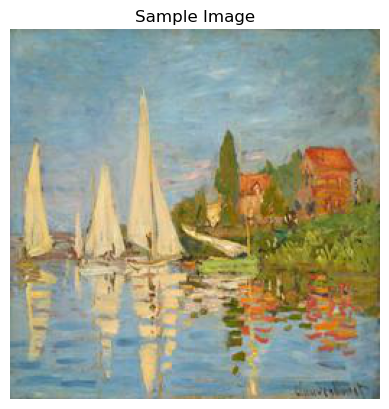

In [6]:
img_path = os.path.join(monet_jpg_folder, os.listdir(monet_jpg_folder)[0])
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title("Sample Image")
plt.show()

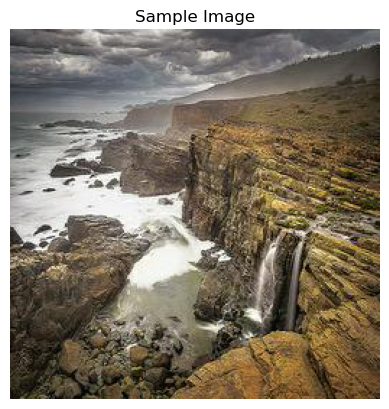

In [7]:
img_path = os.path.join(photo_jpg_folder, os.listdir(photo_jpg_folder)[0])
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title("Sample Image")
plt.show()

#### Image Dimensions

In [8]:
def get_image_shapes(path):
    shapes = []
    for f in os.listdir(path):
        img = Image.open(os.path.join(path, f))
        shapes.append(img.size)
    return Counter(shapes)

print("Monet shapes:", get_image_shapes('gan_images/monet_jpg'))
print("Photo shapes:", get_image_shapes('gan_images/photo_jpg'))

Monet shapes: Counter({(256, 256): 300})
Photo shapes: Counter({(256, 256): 7038})


All of the photos are of size 256x256 pixels.

### Data Preprocessing

Rescaling the images to the 0 to 1 range

In [9]:
monet_dataset = keras.utils.image_dataset_from_directory(
    "gan_images/monet_jpg",
    label_mode=None,
    image_size=(256, 256),
    batch_size=32
)

monet_dataset = monet_dataset.map(lambda x: x / 255.0)


photo_dataset = keras.utils.image_dataset_from_directory(
    "gan_images/photo_jpg",
    label_mode=None,
    image_size=(256, 256),
    batch_size=32
)

photo_dataset = photo_dataset.map(lambda x: x / 255.0)


Found 300 files.
Found 7038 files.


### Data Modeling/Generation

This model was taken from https://keras.io/examples/generative/cyclegan/ and adapted to fit this dataset. The model contains a few parts to it. 

This model has a generator that translates photos into the Monet style and a discriminator that distinguishes between real and fake photos. The model is trained to generate photos in the Monet style that look like the images provided. Essentially, we input RGB images of size 256x256 pixels that are normalized to [-1, 1] and the model outputs images of the same shape and format but with a Monet painting style.

In [10]:
input_img_size = (256, 256, 3)
batch_size = 1
AUTOTUNE = tf.data.AUTOTUNE

def normalize_img(img):
    img = ops.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def preprocess_image(file_path, train=True):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    if train:
        img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, input_img_size[:2])
    img = normalize_img(img)
    return img

def get_dataset_from_dir(path, train=True):
    files = tf.data.Dataset.list_files(os.path.join(path, "*.jpg"))
    dataset = files.map(lambda x: preprocess_image(x, train), num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

photo_dataset = get_dataset_from_dir("gan_images/photo_jpg", train=True)
monet_dataset = get_dataset_from_dir("gan_images/monet_jpg", train=True)

train_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

In [12]:
def preprocess_train_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.image.random_flip_left_right(image)
    image = (image / 127.5) - 1
    return image

In [15]:
buffer_size = 256
batch_size = 1
AUTOTUNE = tf.data.AUTOTUNE
IMG_HEIGHT = 256
IMG_WIDTH = 256

train_photos = (
    tf.data.Dataset.list_files("gan_images/photo_jpg/*.jpg")
    .map(preprocess_train_image, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

train_monets = (
    tf.data.Dataset.list_files("gan_images/monet_jpg/*.jpg")
    .map(preprocess_train_image, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [16]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = padding

    def call(self, input_tensor):
        pad_w, pad_h = self.padding
        return tf.pad(
            input_tensor,
            paddings=[[0, 0], [pad_h, pad_h], [pad_w, pad_w], [0, 0]],
            mode="REFLECT"
        )

In [17]:
def residual_block(
    x,
    activation=None,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    if activation is None:
        activation = layers.Activation("relu")

    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)

    return layers.add([input_tensor, x])

In [18]:
def downsample(
    x,
    filters,
    activation=None,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    if activation is None:
        activation = layers.Activation("relu")

    x = layers.Conv2D(
        filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    return activation(x)

In [19]:
def upsample(
    x,
    filters,
    activation=None,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    if activation is None:
        activation = layers.Activation("relu")

    x = layers.Conv2DTranspose(
        filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    return activation(x)

In [20]:
def build_generator(img_shape=(256, 256, 3), name="generator"):
    inputs = layers.Input(shape=img_shape)

    x = ReflectionPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(
        64,
        kernel_size=(7, 7),
        padding="valid",
        kernel_initializer=kernel_init,
        use_bias=False,
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_init)(x)
    x = layers.Activation("relu")(x)

    x = downsample(x, 128)
    x = downsample(x, 256)

    for _ in range(9):
        x = residual_block(x)

    x = upsample(x, 128)
    x = upsample(x, 64)

    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, kernel_size=(7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    return keras.Model(inputs, x, name=name)

In [21]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    input_shape=(256, 256, 3),
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    name="generator",
):

    img_input = layers.Input(shape=input_shape, name=f"{name}_img_input")

    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(
        filters,
        kernel_size=(7, 7),
        padding="valid",
        kernel_initializer=kernel_initializer,
        use_bias=False
    )(x)
    x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(
            x,
            filters=filters,
            activation=layers.Activation("relu"),
            kernel_initializer=kernel_initializer,
            gamma_initializer=gamma_initializer,
        )

    for _ in range(num_residual_blocks):
        x = residual_block(
            x,
            activation=layers.Activation("relu"),
            kernel_initializer=kernel_initializer,
            gamma_initializer=gamma_initializer,
        )

    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(
            x,
            filters=filters,
            activation=layers.Activation("relu"),
            kernel_initializer=kernel_initializer,
            gamma_initializer=gamma_initializer,
        )

    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, kernel_size=(7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    return keras.models.Model(inputs=img_input, outputs=x, name=name)

In [22]:
def get_discriminator(
    filters=64,
    input_shape=(256, 256, 3),
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    num_downsampling=3,
    name="discriminator"
):

    img_input = layers.Input(shape=input_shape, name=f"{name}_img_input")

    x = layers.Conv2D(
        filters,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for i in range(num_downsampling):
        num_filters *= 2
        stride = (2, 2) if i < 2 else (1, 1)

        x = layers.Conv2D(
            num_filters,
            kernel_size=(4, 4),
            strides=stride,
            padding="same",
            kernel_initializer=kernel_initializer,
            use_bias=False
        )(x)
        x = layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
        x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(
        1,
        kernel_size=(4, 4),
        strides=(1, 1),
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)

    return keras.models.Model(inputs=img_input, outputs=x, name=name)

In [23]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, test_dataset, num_img=4, output_dir="generated"):
        super().__init__()
        self.test_dataset = test_dataset
        self.num_img = num_img
        self.output_dir = output_dir

        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(self.num_img, 2, figsize=(12, 3 * self.num_img))

        for i, img_batch in enumerate(self.test_dataset.take(self.num_img)):
            input_img = img_batch[0]
            translated_img = self.model.gen_G(tf.expand_dims(input_img, 0), training=False)[0]

            input_img_np = ((input_img + 1.0) * 127.5).numpy().astype(np.uint8)
            translated_img_np = ((translated_img + 1.0) * 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(input_img_np)
            ax[i, 1].imshow(translated_img_np)
            ax[i, 0].set_title("Input Photo")
            ax[i, 1].set_title("Translated Monet")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            img_to_save = keras.utils.array_to_img(translated_img_np)
            img_to_save.save(f"{self.output_dir}/epoch_{epoch + 1}_img_{i}.png")

        plt.tight_layout()
        plt.show()
        plt.close()

In [24]:
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

In [25]:
class MonetGAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_optimizer, disc_optimizer, loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn
        self.gen_loss_metric = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_metric = keras.metrics.Mean(name="disc_loss")

    @property
    def metrics(self):
        return [self.gen_loss_metric, self.disc_loss_metric]

    def train_step(self, batch_data):
        real_photos, real_monets = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monets = self.generator(real_photos, training=True)

            disc_real_output = self.discriminator(real_monets, training=True)
            disc_fake_output = self.discriminator(fake_monets, training=True)

            gen_loss = self.loss_fn(tf.ones_like(disc_fake_output), disc_fake_output)

            disc_real_loss = self.loss_fn(tf.ones_like(disc_real_output), disc_real_output)
            disc_fake_loss = self.loss_fn(tf.zeros_like(disc_fake_output), disc_fake_output)
            disc_loss = 0.5 * (disc_real_loss + disc_fake_loss)

        gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        self.gen_loss_metric.update_state(gen_loss)
        self.disc_loss_metric.update_state(disc_loss)

        return {
            "gen_loss": self.gen_loss_metric.result(),
            "disc_loss": self.disc_loss_metric.result()
        }


In [27]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                               kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x)

disc_Y = build_discriminator()

In [28]:
monet_gan = MonetGAN(generator=gen_G, discriminator=disc_Y)

monet_gan.compile(
    gen_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=keras.losses.MeanSquaredError()
)

In [29]:
monet_gan.fit(
    tf.data.Dataset.zip((train_photos, train_monets)),
    epochs=50,
    callbacks=[GANMonitor(test_dataset=test_photos)]
)

### Results

This model is designed to learn the style of Monet paintings and apply it to the real world images provided. The problem is that this model requires a lot of CPU and RAM to run and therefore will take over hours to generate the photos needed.

### Conclusion

Since my laptop is old and does not have a lot of CPU and RAM, I was not able to fully run this project, but I did write the code for a one-way GAN. Because of this, I have learned about the importance of considering efficiency and time complexity in the model, especially when hardware is hindering. 

If I had more time to work on this project, I would try to simplify the model so that I can run it. I would also try to tune hyperparameters and see what combination gives me the best results.